### Place cell identification pipeline 2.0
1. Read in aligned events df
2. Import animal name, session, stage (start with one PRE+SAM?)
4. Omit startbox activity (excludes the posibility for sharpe wave ripples) 
5. Omit points when the animal is not moving
6. Binarize events to start (later we can bin them)
7. Bin arena into 4x4cm bins 
7. Calculate Kraskov spatial information (SI)
8. Shuffle neural events 5000 times Does our place cell stand within the 99% percentile
9. Cell fires at least 3 times
10. Spatial occupancy > 5
11. Events occur at least 2% of the total time in the place field





 


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl

#1. select animal name, session, stage
animal = 'H2203'
session = 'A02'
stage = 'CHO' #Any stage but

#2. Read in aligned events df & 
directory = '/Users/rufusmitchell-heggs/Desktop/data_analysis/preprocessing/event_arena/'
file = animal+'/'+animal+'_AAL_event_dlc.csv'
meta = pd.read_csv(directory+file)
meta = meta.loc[(meta['Session']==session) & (meta['stage']!=stage)]

In [254]:
#3. Remove all start box activity
a_meta = meta[meta['position']!=12]
a_meta = a_meta[a_meta['position']!=str(12)]

#4. Only analyse moving points
mov_meta = a_meta[a_meta['Movement status']=='moving']

#6. Bin arena <----- DEFINE CONSISTENT ARENA
pix_cm = 5
pf_cm = 4
x = mov_meta['x'].values.astype(float)
y = mov_meta['y'].values.astype(float)
arena_x = int(max(x) - min(x))
arena_y = int(max(y) - min(y))
nBinsx = int((arena_x/(pix_cm*pf_cm)))
nBinsy = int((arena_y/(pix_cm*pf_cm)))


bins_x = [int(i) for i in np.linspace(max(x),min(x),nBinsx)]
bins_y = [int(i) for i in np.linspace(max(y),min(y),nBinsy)]
bx = ((x-bins_x[0])/(bins_x[1]-bins_x[0])).astype(int)
by = ((y-bins_y[0])/(bins_y[1]-bins_y[0])).astype(int)
S = np.vstack((bx,by))
linS = np.ravel_multi_index(S,(nBinsx,nBinsy))
occMap = sps.csr_matrix((np.ones(len(bx)),(bx,by)),shape=(nBinsx,nBinsy),dtype=float).todense()

#5. Isolate and binarize events
e_traces = mov_meta[mov_meta[[col for col in mov_meta if col.startswith(' C')]]
                    .loc[:,~(mov_meta[[col for col in mov_meta if col.startswith(' C')]] == " nan").any()].columns.values]
e_traces[e_traces > 0] = 1
e_traces = e_traces.values.T

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [255]:
place_Maps = []
for ev in e_traces[:1]:
    rateMap = sps.csr_matrix((ev,(bx,by)),shape=(nBinsx,nBinsy),dtype=float).todense()
    placeMap = rateMap/occMap; placeMap[np.isnan(placeMap)] = 0
    placeMap = gaussian_filter(placeMap, sigma = 1.5)
    place_Maps.append(placeMap)
    res_eve = list(ev.reshape(-1,1))
    
    #6. calculate SI
    si = mi_skl(res_eve, linS, discrete_features=True,n_neighbors=3)
    
    #7. Create distribution of SI with shuffled events
    shuffles = 1000
    SI = []
    for i in range(shuffles): # Use GPU or parallel processing
        np.random.shuffle(res_eve)
        SI.append(mi_skl(res_eve, linS, discrete_features=True,n_neighbors=3))
        if i == 100:
            print(i, 'shuffles')

    #8. Calculate percentile
    perc = stats.percentileofscore(SI, si)

[0.00080029] 97.8


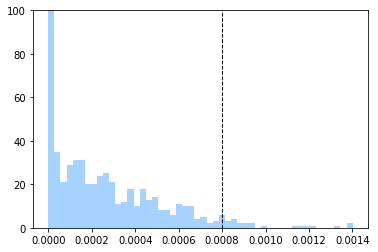

In [285]:
import seaborn as sns
from scipy import stats

# plt.figure(num=None, figsize=(5, 2), dpi=200, facecolor='w', edgecolor='k')
# plt.hist(dist[27], bins = 50, color = 'dodgerblue')

sns.distplot(SI, bins = 50,  color = 'dodgerblue', kde=False)
plt.ylim(0,100)
plt.axvline(si, color='k', linestyle='dashed', linewidth=1)
print(si, stats.percentileofscore(SI, si))


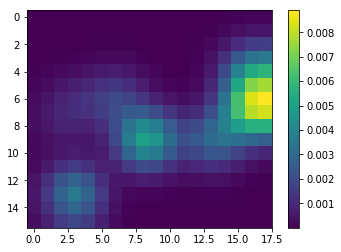

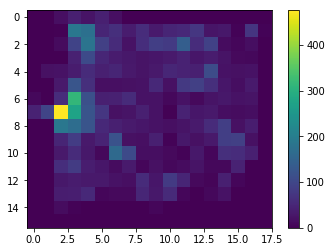

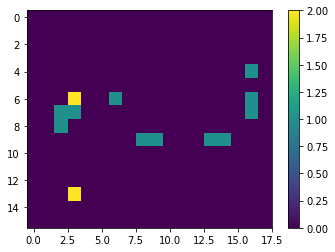

In [296]:
plt.imshow(place_Maps[0])
plt.colorbar()
plt.show()

plt.imshow(occMap)
plt.colorbar()
plt.show()

plt.imshow(place_Map)
plt.colorbar()
plt.show()

2.0